Importing all necessary libraries and opening up the World Cup 2022 data through Statsbomb (competition_id = 43 and season_id = 106).

In [1]:
import matplotlib.pyplot as plt
from mplsoccer import Sbopen, VerticalPitch
import pandas as pd
import numpy as np
import scipy.stats as stats

parser = Sbopen()
df_match = parser.match(competition_id=43, season_id=106)

Croatia had another brilliant run at the World Cup 2022 in Qatar and finished third. I wanted to compare two of Croatia's left-wingers Perišić and Oršić who both had a similarly successful impact with 7 goal involvements (2 goals and 5 assists) shared between the two. Focusing on Mislav Oršić as a debutant at the WC for Croatia after an impressive couple of seasons with Dinamo Zagreb. Isolating only Croatia's matches at the World Cup 2022.

In [ ]:
Croatia_matches = []

for i, matches in enumerate(df_match["match_id"]):
    if df_match["home_team_country_name"].iloc[i] == "Croatia" or df_match["away_team_country_name"].iloc[i] == "Croatia":
        Croatia_matches.append(matches)

print(Croatia_matches)

[3869684, 3869519, 3869420, 3869219, 3857296, 3857281, 3857277]


Isolating all events Perišić and Oršić participated in. This analysis's main focus will be on these players' attacking actions (forward passes).

In [ ]:
df_targets = pd.DataFrame()

for matches in Croatia_matches:
    match_id = matches
    df_event, df_related, df_freeze, df_tactics = parser.event(match_id)
    df_targets = pd.concat([df_targets, df_event], ignore_index=True)

df_targets = df_targets[df_targets ["player_name"].isin(["Ivan Perišić", "Mislav Oršić"])]

Isolating all successful passes by these two players that ended in the penalty box (end_x >= 102 Y1 >= 18 & Y1 <= 62).

In [ ]:
df = df_targets[df_targets["type_name"] == "Pass"]
df = df[~df["outcome_name"].isin(["Incomplete", "Out", "Unknown", "Pass Offside"])]
filtered_df = df[~((df["end_y"] <= 18))]
filtered_df = filtered_df[~((df["end_y"] >= 62))]
filtered_df = filtered_df[~((df["end_x"] <= 102))]

df_Orsic = filtered_df[filtered_df["player_name"] == "Mislav Oršić"]
df_Perisic = filtered_df[filtered_df["player_name"] == "Ivan Perišić"]
df_Assists = filtered_df[filtered_df["pass_goal_assist"] == True]
df_Assists_Orsic = df_Assists[df_Assists["player_name"] == "Mislav Oršić"]
df_Assists_Perisic = df_Assists[df_Assists["player_name"] == "Ivan Perišić"]

print(df_Orsic.shape)
print(df_Perisic.shape)

(8, 85)
(13, 85)


Plotting successful passes into the box by Oršić (blue) and Perišić (red). Highlighting ones that were assists with circles. Trying to show Oršić's more direct vertical approach to the box while Perišić tends to go to the wing and cross the ball in the box. Both players offer unique attacking styles. Oršić is right-footed so he tends to cut in while Perišić is a left-footed winger that tends to use the flank more often to pass the ball horizontally into the penalty box.

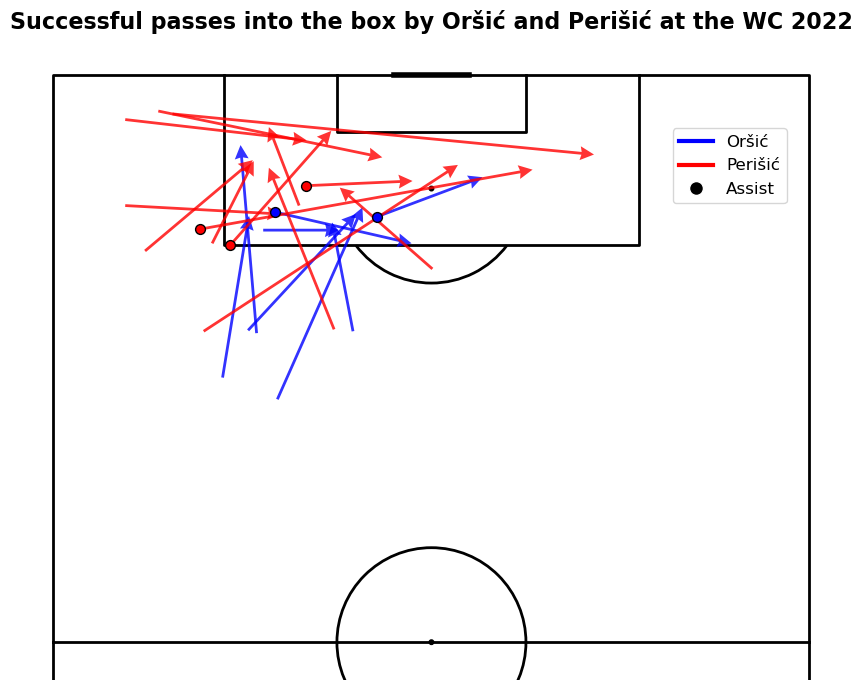

In [ ]:
pitch = VerticalPitch(line_color="black", half=True)
fig, ax = pitch.draw(figsize=(10, 7))

pitch.arrows(df_Orsic["x"], df_Orsic["y"], 
             df_Orsic["end_x"], df_Orsic["end_y"], 
             color="blue", ax=ax, width=2, headwidth=5, headlength=5, alpha=0.8)

pitch.arrows(df_Perisic["x"], df_Perisic["y"], 
             df_Perisic["end_x"], df_Perisic["end_y"], 
             color="red", ax=ax, width=2, headwidth=5, headlength=5, alpha=0.8)

pitch.scatter(df_Assists_Orsic["x"], df_Assists_Orsic["y"], 
              color="blue", s=50, ax=ax, alpha=1.0, edgecolor="black")

pitch.scatter(df_Assists_Perisic["x"], df_Assists_Perisic["y"], 
              color="red", s=50, ax=ax, alpha=1.0, edgecolor="black")

ax.set_title("Successful passes into the box by Oršić and Perišić at the WC 2022", fontsize=16, fontweight="bold")

legend_elements = [
    plt.Line2D([0], [0], color="blue", lw=3, label="Oršić"),
    plt.Line2D([0], [0], color="red", lw=3, label="Perišić"),
    plt.Line2D([0], [0], marker="o", color="w", label="Assist", 
               markerfacecolor="black", markersize=10, markeredgecolor="white")
]


ax.legend(handles=legend_elements, loc="center left", bbox_to_anchor=(0.78, 0.8), fontsize=12)
#plt.savefig("Successful passes into the box by Oršić and Perišić at the WC 2022.png", dpi=900)
plt.show()

Now, it is time to compare Oršić and Perišić with other players who performed well at the World Cup 2022, as a threshold of good performance for a player, 2 or more assists were chosen. The reasoning is that those players had an impact through passes into the box and helped their team score goals. Twenty players had 2 or more assists at the World Cup 2022 which is a good collective for comparison. Each player's total passes into the box, their success rate, and the number of minutes played for normalization are calculated.

In [ ]:
targets = ["Mislav Oršić","Ivan Perišić","Bruno Miguel Borges Fernandes","Lionel Andrés Messi Cuccittini","Harry Kane","Antoine Griezmann",
           "Kylian Mbappé Lottin","Dušan Tadić","Jordi Alba Ramos","Theo Bernard François Hernández","Philip Foden","Christian Pulisic",
           "Andrija Živković","Raphaël Adelino José Guerreiro","João Félix Sequeira","Vinícius José Paixão de Oliveira Júnior",
            "Denzel Dumfries","Ousmane Dembélé","Marcus Thuram","Davy Klaassen"]

pass_stats = {}

for matches in df_match["match_id"]:
    match_id = matches
    df_event, df_related, df_freeze, df_tactics = parser.event(match_id)
    players = df_event["player_name"].unique()
    for target in targets:
        if target in players:
            passes_box = df_event[(df_event["player_name"] == target) & (df_event["type_name"] == "Pass")
                                    & (df_event["end_y"] >= 18) & (df_event["end_y"] <= 62) & (df_event["end_x"] >= 102)]
                    
            successful_passes_box = passes_box[passes_box["outcome_name"].isna()]
            total_passes = len(passes_box)
            success_count = len(successful_passes_box)
                    
            if target not in pass_stats:
                pass_stats[target] = {
                    "passes_into_box": 0,
                    "successful_passes_box": 0,
                    "minutes_played": 0
                    }
                    
            pass_stats[target]["passes_into_box"] += total_passes
            pass_stats[target]["successful_passes_box"] += success_count
                    
            player_events = df_event[df_event["player_name"] == target]
            if not player_events.empty:
                first_minute = player_events["minute"].min()
                last_minute = player_events["minute"].max()
                pass_stats[target]["minutes_played"] += (last_minute - first_minute)

Previously calculated data in pass_stats will be used to make a Scatter Plot to compare the total number of passes into the box per 90 with the success rate of passes for the 20 players with 2 or more assists at the World Cup 2022 (with z-score for success rate of passes into box). Passes into the box will be normalized for minutes played.

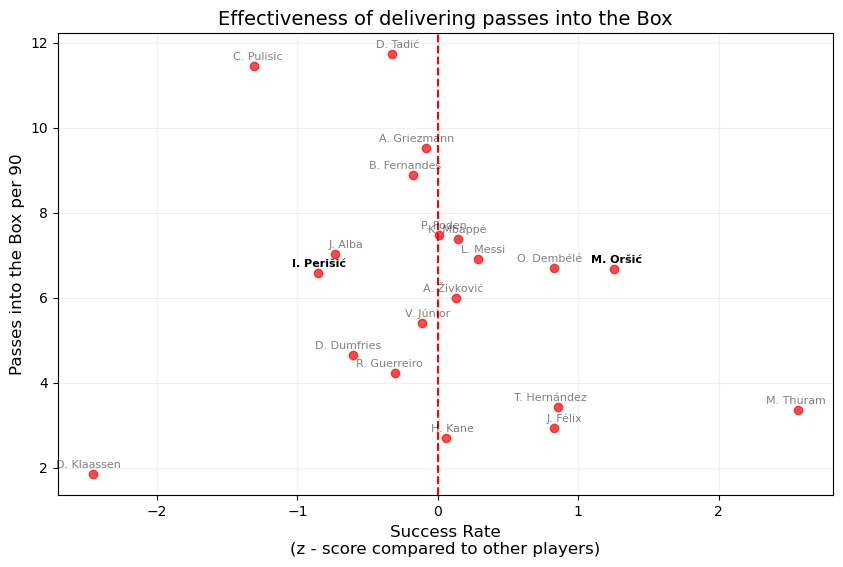

In [ ]:
data = pass_stats

players = list(data.keys())     
passes_box = np.array([data[player]["passes_into_box"] for player in players])
successful_passes_box = np.array([data[player]["successful_passes_box"] for player in players])
minutes_played = np.array([data[player]["minutes_played"] for player in players])

success_rates = successful_passes_box / passes_box
passes_box_per_90 = (passes_box / minutes_played) * 90
z_scores = stats.zscore(success_rates)

plt.figure(figsize=(10, 6))
plt.scatter(z_scores, passes_box_per_90, color="red", alpha=0.7)

for i, player in enumerate(players):
    if player == "Lionel Andrés Messi Cuccittini":
        short_name = "L. Messi"
    elif player == "Kylian Mbappé Lottin":
        short_name = "K. Mbappé"
    elif player == "Jordi Alba Ramos":
        short_name = "J. Alba"
    elif player == "João Félix Sequeira":
        short_name = "J. Félix"
    else:
        full_name = player.split()
        first_name_initial = full_name[0][0]
        surname = full_name[-1]
        short_name = f"{first_name_initial}. {surname}"
    if player == "Mislav Oršić" or player == "Ivan Perišić":
        plt.text(z_scores[i]+0.2, passes_box_per_90[i]+0.14, short_name, fontsize=8, ha="right",weight ="bold")
    else:
        plt.text(z_scores[i]+0.2, passes_box_per_90[i]+0.14, short_name, fontsize=8, ha="right",alpha=0.5)

plt.axvline(x = 0, color = "red", label = "axvline - full height", linestyle="dashed")
plt.title("Effectiveness of delivering passes into the Box", fontsize=14)
plt.xlabel("Success Rate\n(z - score compared to other players)", fontsize=12)
plt.ylabel("Passes into the Box per 90", fontsize=12)
plt.grid(alpha=0.2)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

#plt.savefig("Effectiveness of delivering passes into the Box.png", dpi=900)
plt.show()